<a href="https://colab.research.google.com/github/mrezky-mr/ASPIRE2021/blob/main/Simple_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this model, I tried to simulate the cloud collapse without taking into account the stellar fields. This means that I'm only adding particles into the simulation.

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jul  2 00:42:22 2021

@author: mrezky
"""

#some initialization
import rebound
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

sim = rebound.Simulation()
sim.units = ('yr','au','kg')

#I'm running this code on my campus server, so I have to turn off the interactivity of mpl codes
plt.ioff()
mpl.use('Agg')

In [ ]:
#integrator options
sim.integrator = "ias15"
sim.dt = 0.025*2.*np.pi # we're working in units where 1 year = 2*pi
sim.testparticle_type = 1
sim.ri_ias15.min_dt = 1e-6 # ensure that close encounters do not stall the integration 

I've tried Mercurius (from [Rein's example](https://rebound.readthedocs.io/en/latest/ipython_examples/PrimordialEarth.html)) and IAS15 (the one that I have experience with it). It seems that the energy offset from Mercurius is a bit high than IAS15 (which just in order of $10^{-2}$).

For the *sim.testparticle_type = 1*, I use it because we want to see all particles interacting with each other.

The *im.ri_ias15.min_dt = 1e-6* is coming from the example.

**Question**:
1.   How we choose what kind of integrator that we'll use in the future?
2.   What was the reasoning behind the *im.ri_ias15.min_dt = 1e-6* line? How would close encounters stall the integration?



For the next part, I am activating the collision effect as *direct* collision, which will always resulted in *merge* of involved particles. In the end, I will present each remaining particle's mass and radius.

In [ ]:
#collision and boundary options
sim.collision = "direct"
sim.collision_resolve = "merge"
sim.collision_resolve_keep_sorted = 1
sim.track_energy_offset = 1

Establishing the uniformed random variable generator. Straight from the [Rein's example](https://rebound.readthedocs.io/en/latest/ipython_examples/PrimordialEarth.html).

In [ ]:
def rand_uniform(minimum, maximum):
    return np.random.uniform()*(maximum-minimum)+minimum

For this part below, I used some assumption from Rein et al. (2010) paper, with radius
> $$R = H = 0.01 \ AU$$ 

(which also the Hill radius of the Earth), surface solid density of the disk

> $$\rho_{s} = 8900 \ kg \ m^{-3}$$

(from the MMSN parameters, with $\rho_s = 890 \ g \ cm^{-2}$ and solid to gas ratio $\rho_s/\rho_g = 0.01$). This means that the total mass of the disk is $436310597.1 \ kg$.

Using 10,000 as the amount of particles involved in the simulation and the equation

> $$a_{num} = \frac{0.014}{\sqrt{N_{num}}} \ AU$$

In the end, each particle's properties are $a_{num} = 1.4 \cdot 10^{-4} \ AU$ and $m_{num} = 4.36 \cdot 10^4 \ kg$. (**Question**: Is this right? Is this the intended result from using scaled particles?)

In [ ]:
N_pl = 10000                        # Number of planetesimals
Mtot_disk = 436310597.1             # Total mass of planetesimal disk, in kg
m_pl = Mtot_disk / float(N_pl)      # Mass of each planetesimal
r_pl = 1.4e-4                       # Radius of each planetesimal, in au
sch = 0.01                          # Scale-height of the disk
v_dp = 1.3368984e-12                # Maximum velocity dispersion, in au/s

**Update** (05/07): I've revise the inclination part, so that it will uphold the $H/R_0 = 0.01$ assumption in the initial model.

**Update** (06.07): 

*   I've added the code so each particle get their own initial velocity, with range between $0 - 0.2 \ m/s$.
*   I've revised the code so particle distribution will be uniform across the disk and their $z$ upholds the $H/R_0$ assumption.

In [ ]:
np.random.seed(50) #by setting a seed we will reproduce the same simulation every time
while sim.N < (N_pl + sim.N_active):
    r = rand_uniform(0, 0.01)
    x = rand_uniform(-r, r)
    y = rand_uniform(-np.sqrt(r**2 - x**2), np.sqrt(r**2 - x**2))
    z = rand_uniform(-abs(x)*sch, abs(x)*sch)
    if y >= 0:
        vx = rand_uniform(-v_dp, 0)
    else:
        vx = rand_uniform(0, v_dp)
    if x >= 0:
        vy = rand_uniform(0, v_dp)
    else:
        vy = rand_uniform(-v_dp, 0)
    p = rebound.Particle(simulation=sim, m=m_pl, r=r_pl, x=x, y=y, z=z, vx=vx, vy=vy, vz=0)
    sim.add(p)

In [ ]:
sim.move_to_com()
E0 = sim.calculate_energy()

In [ ]:
#plotting the particles in the initial condition
coords = np.zeros((3,sim.N))
for i in range(sim.N):
    coords[0][i], coords[1][i], coords[2][i] = sim.particles[i].x, sim.particles[i].y, sim.particles[i].z
fig1 = plt.figure(figsize=(15,7)) 
ax1 = plt.subplot(121)
ax1.axis('equal')
ax1.scatter(coords[0],coords[1], s=2)
ax1.scatter(sim.particles[0].x,sim.particles[0].y, s=2)
plt.xlabel('X')
plt.ylabel('Y')
ax2 = plt.subplot(122)
ax2.scatter(coords[0],coords[2], s=2)
ax2.scatter(sim.particles[0].x,sim.particles[0].z, s=2)
ax2.set_ylim(min(coords[2])*2, max(coords[2]*2))
plt.xlabel('X')
plt.ylabel('Z')
plt.savefig("initial.png")
plt.close(fig1)

This is the initial state of the simulation that I run by myself. (**Updated** on 06/07)

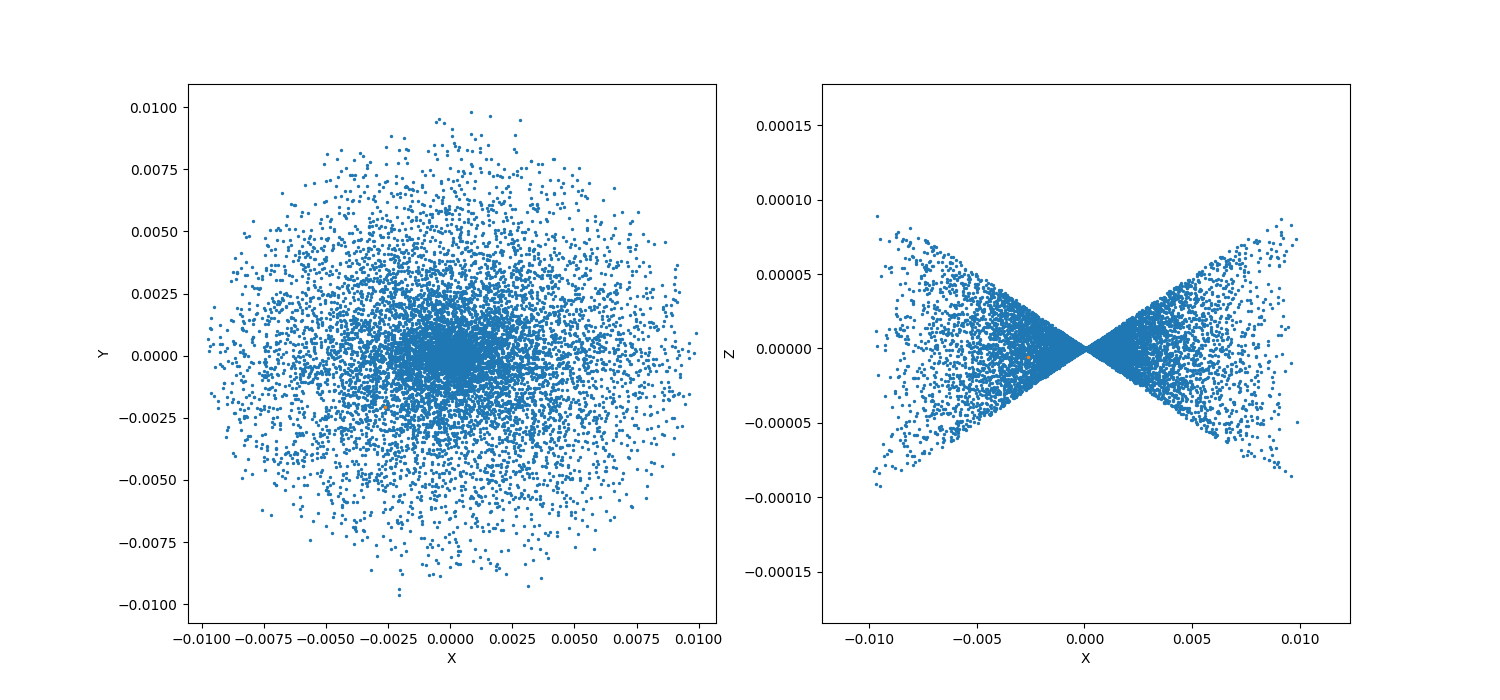

In [ ]:
#integrate all particles for about 318 orbits
times = np.linspace(0.,2000.,2000)
totalN = np.zeros(len(times))
errors = np.zeros(len(times))
for i,t in enumerate(times):
    sim.integrate(t)
    totalN[i] = sim.N
    errors[i] = abs((sim.calculate_energy() - E0)/E0)
    if t % 100 < 1:
        coords = np.zeros((5,sim.N))
        for i in range(sim.N):
            coords[0][i], coords[1][i], coords[2][i] = sim.particles[i].x, sim.particles[i].y, sim.particles[i].z
            coords[3][i], coords[4][i] = sim.particles[i].vx, sim.particles[i].vy
        fig2, ax3 = plt.subplots()
        plt.title("t_{a}".format(a=int(t)), loc='right')
        ax3.axis('equal')
        ax3.scatter(coords[0],coords[1], s=2)
        ax3.scatter(sim.particles[0].x,sim.particles[0].y, s=2)
        ax3.quiver(coords[0],coords[1],coords[3],coords[4])
        plt.xlabel('X')
        plt.ylabel('Y')
        fig2.tight_layout()
        plt.savefig("t_{a}.png".format(a=int(t)))
        plt.close(fig2)
    print(t)

**Update** (06/07): I've revised the code so the plot would also show the velocity vector of each particles. This is the example at $t=500$ orbits and $t = 1000$ orbits.

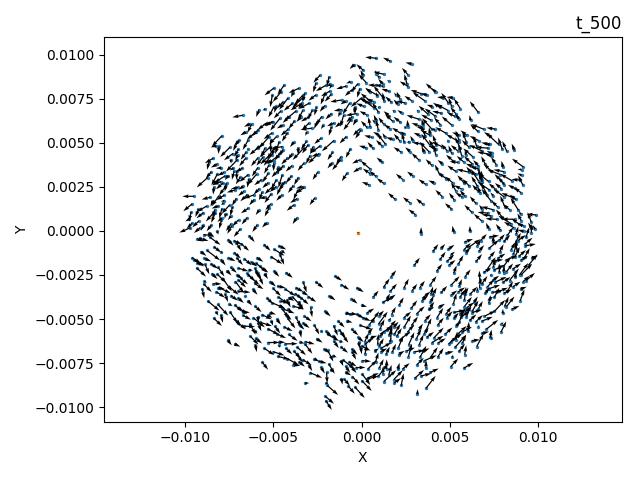

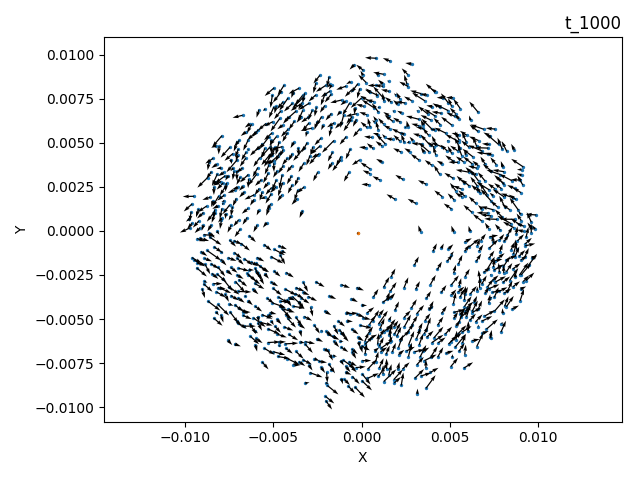

In [ ]:
#plotting the final status of the system, adopted from Rein's example.
fig3 = plt.figure(figsize=(10,7))

axa = plt.subplot(211)
plt.yscale("log")
plt.plot(times/(2.*np.pi), errors)
axa.set_ylabel("Relative energy error")

axb = plt.subplot(212)
axb.set_ylabel("Lost/merged particles")
axb.set_xlabel("Time [orbits]")
plt.plot(times/(2.*np.pi), -(totalN-N_pl-2))
plt.savefig("stats.png")
plt.close(fig3)

This is the result of the code above. As I said before, the IAS15 integrator generate a relative energy error in the order of $10^{-2}$. Honestly, the second plot doesn't really help, so I tried to extract the mass, radius and velocity of the remaining particles.

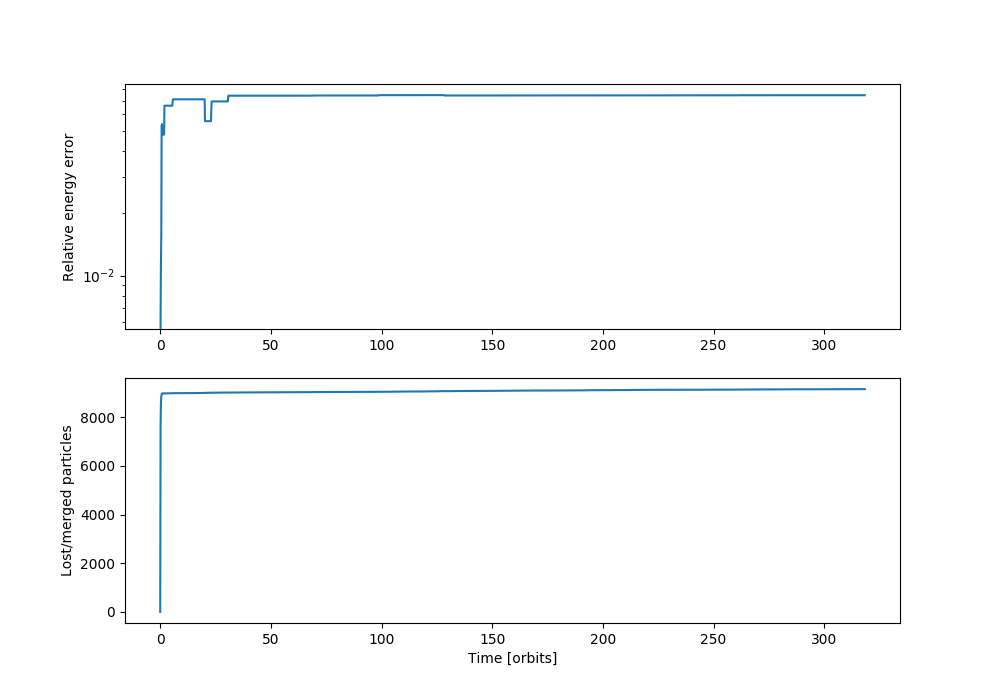

In [ ]:
p_mass = []
p_rad = []
p_v = []

coords = np.zeros((3,sim.N))
for i in range(sim.N):
    coords[0][i], coords[1][i], coords[2][i] = sim.particles[i].x, sim.particles[i].y, sim.particles[i].z
    p_mass.append(sim.particles[i].m)
    p_rad.append(sim.particles[i].r)
    x = np.array([sim.particles[i].vx, sim.particles[i].vy])
    p_v.append(np.linalg.norm(x)*149597870700)
    
dat = np.vstack((p_mass, p_rad, p_v))
np.savetxt("final_pdata.txt", dat)
    
fig4 = plt.figure(figsize=(15,7)) 
ax5 = plt.subplot(121)
ax5.axis('equal')
ax5.scatter(coords[0],coords[1], s=2)
ax5.scatter(sim.particles[0].x,sim.particles[0].y, s=2)
plt.xlabel('X')
plt.ylabel('Y')
ax6 = plt.subplot(122)
ax6.scatter(coords[0],coords[2], s=2)
ax6.scatter(sim.particles[0].x,sim.particles[0].z, s=2)
ax6.set_ylim(min(coords[2])*2, max(coords[2]*2))
plt.xlabel('X')
plt.ylabel('Z')
plt.savefig("final.png")
plt.close(fig4)

This is the plot for the end of the simulation. For the rest of the plots (the one for every 100 timestamps) and the radius-mass txt, you can found it on [my drive here](https://drive.google.com/drive/folders/1xoCq1UumR4f1Z3cdqaep-TV7h6W1l5Ll?usp=sharing).

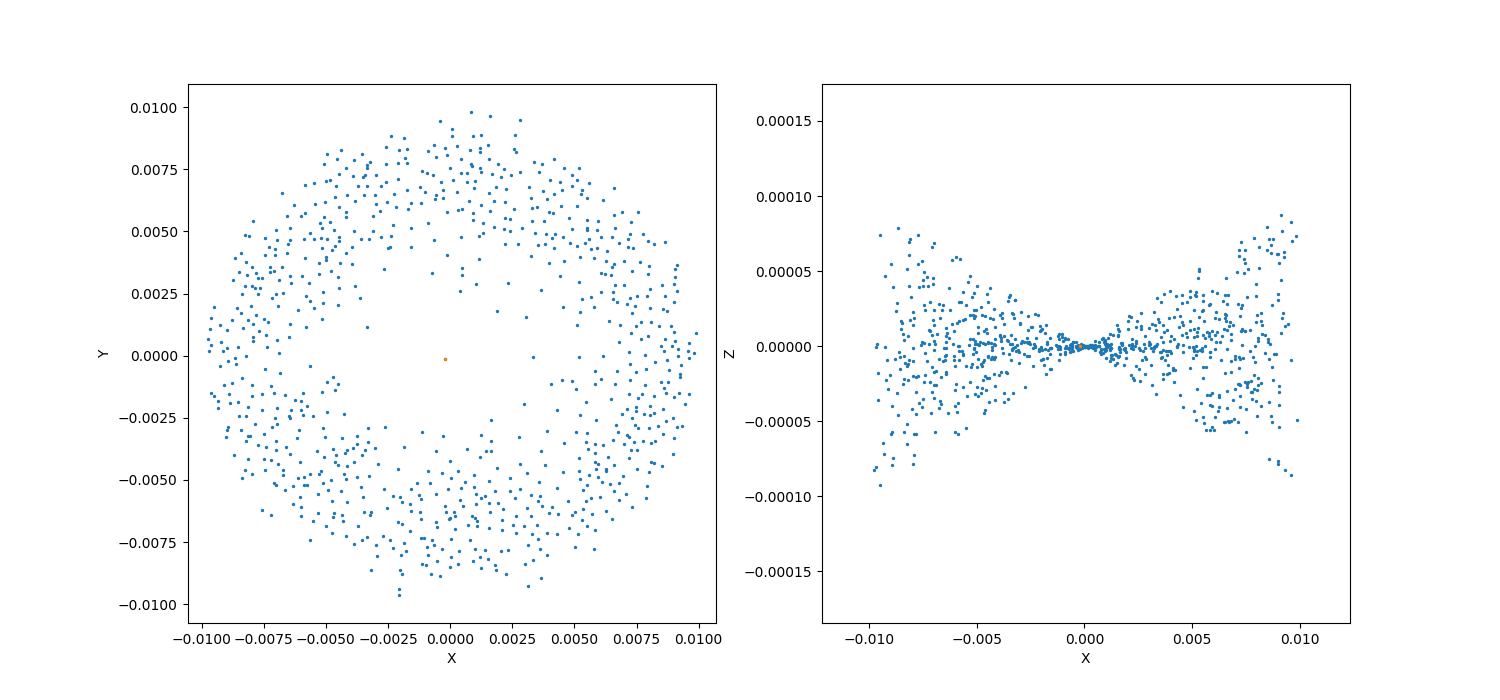

By the end of the simulation, the velocity of each particles ranges between $0.012 - 0.2897 \ m/s$, the mass ranges between the initial mass to $2.17 \cdot 10^8 \ kg$ and the radius ranges between the initial radius to $2.39 \cdot 10^{-3} \ AU$.

*To-do list*: Implement the tree code algorithm.